# Final Project CompStats | Timo Haupt | SoSe 2021

---

# Performance of Causal Forests in Identifying Heterogeneous Treatment Effects

---

**Importing Packages:**

In [2]:
suppressMessages(library(grf))
suppressMessages(library(FNN))
suppressMessages(library(MASS))
suppressMessages(library(foreign))
suppressMessages(library(dplyr))

**Importing Functions:**

In [3]:
source("material/auxiliary.R")

## Structure

[**1. Theoretical Discussion**](#theory)
   * [Causal Tree](#tree)
   * [Causal Forest](#forest)
    
[**2. Simulation Study**](#simulation)
   * [Data Generating Process](#dgp)
   * [Performance Measure](#performance)
   * [Variations](#simstudy)

[**3. Application**](#application)
   * [Lalonde Data Set](#lalonde)
   * [Causal Forest Estimations](#causalforest)

[**4. Conclusion**](#conclusion)

[**5. References**](#references)

## 1.) Theoretical Discussion<a id="theory"></a>

This first section introduces how causal tree and causal forest estimation methods work, and describes how treatment estimation is conducted. The main problem in settings dealing with causality and inference is the missing counterfactual. Particularly in estimating treatment effects it's only possible to observe an individual with treatment, $Y_i^{(1)}$, or without treatment, $Y_i^{(0)}$, but never both. Therefore, we are in the Potential Outcome Framework where we "posit the existence of potential outcomes $Y_i^{(1)}$ and $Y_i^{(0)}$ corresponding respectively to
the response the $i$-th subject would have experienced with and without the treatment" (Athey & Wager 2015).

The causal forest estimation method tries to find these potential outcomes by some sort of matching in order to estimate the treatment effect 
$$\tau(x) = \mathbb{E}\left[Y_i^{(1)} - Y_i^{(0)} \mid X_i = x\right]. $$

One essential assumption we need to impose in order to theoretically justify the estimation method is unconfoundedness, i.e. "treatment assignment $W_i$ is independent of the potential outcomes for $Y_i$ conditional on $X_i$" (Athey & Wager 2015):

$$\left \{Y_i^{(1)}, Y_i^{(0)} \right \} \perp\!\!\!\perp W_i \mid X_i $$

The idea is that, if unconfoundedness holds, "we can treat nearby observations in x-space as having come from a
randomized experiment; thus, nearest-neighbor matching and other local methods will in general be consistent for $\tau(x)$" (Athey & Wager 2015).

### Causal Tree<a id="tree"></a>

Before explaining how causal forests work, it is essential to describe a single causal tree, since the forest is made up of several thousand trees. Causal trees predict individual treatment effects rather than some output variable $Y$ in the setting of random trees. The estimation method is actually pretty similiar to the K-Nearest-Neighbor method, where based on some distance measure the K nearest observations are chosen and based on these neighbors a potential outcome is constructed. The causal tree also tries to find the most similiar observations, "but now closeness is defined with respect to a decision tree, and the closest points to x are those that fall in the same leaf as it" (Athey & Wager 2015). Therefore, one can check for every individual what are the predictions of observations that are in the same leaf and calculate a value for the potential outcome. 

**Treatment Effect Estimation**

If we take some $x \in R_k$ where $R_k$ is some leaf of the causal tree and define $N_k(w)$ as the number of observations in leaf $R_k$ with treatment status $w \in \{0,1\}$, the Conditional Average Treatment Effect is then estimated "based on the mean difference between the outcome levels of the treated and untreated units" which are in the same leaf $R_k$ by 

$$ \hat{\tau}(x) = \hat{\tau}_{R_k} = \frac{1}{N_k(1)} \sum_{i \in R_k(1)} Y_i-\frac{1}{N_k(0)} \sum_{i \in R_k(0)} Y_i  . $$
So, the causal forest does some sort of matching by recursively partitioning the predictor space and then matching treated and untreated observations that have fallen in the same leaf (see e.g. Hitsch & Misra 2018 and Athey & Wager 2015). Therefore, we can estimate for each observation some specific treatment effect based on it's characteristics $X_i$.

**Splitting Rule & Honest Splitting**

In the setting of causal trees "the algorithm seeks to maximize the treatment effect heterogeneity across partitions at every tree-splitting step" (Farbmacher et al. 2019). Therefore, it uses a splitting rule that maximizes "the variance of the predicted treatment effects $\hat{\tau}(X_i)$ across the observations in the two new leaves" (Hitsch & Misra 2018). In order to assure properties like consistency and asymptotic normality, Athey and Wager (2015) propose the necesity of the so called "Honest Splitting Rule". One way of achieving "Honesty" is the "Double-Sample Tree" which has been applied in all of the estimations in this project. "Double-sample trees split the available training data into two parts: one half for estimating the desired response inside each leaf, and another half for placing splits" (Athey & Wager 2015).


### Causal Forest<a id="forest"></a>

As noted the causal forest consists of multiple thousand single trees, where each tree estimates individual treatment effects for all observations in the sample. "The forest then aggregates their predictions by averaging them: $\hat{\tau}(x) = \frac{1}{B} \sum_{b=1}^B \hat{\tau}_b(x)$", where the default value is $B = 2000$. In the upcoming simulation study the default value has been chosen. 




**Advantages of Causal Forests**

Similiar to random forests, the advantage of causal gorests over single causal trees is that "a random sample of
$m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those m predictors". Hence, this works as "decorrelating the trees, thereby making the average of the resulting trees less variable and hence more reliable" (Hastie et al. 2013). Furthermore, by aggregating $B$ single causal trees and therefore drawing $B$ random training and test samples (see section "Honest Splitting") it also "helps to reduce variance and smooths sharp decision boundaries" (Athey & Wager 2015).

Compared to other matching estimation methods, "the advantage of trees is that their leaves can be narrower along the directions where the signal is changing fast and wider along the other directions" (Athey & Wager 2015). For this reason I will compare the performance of causal forests in settings where correlation between some regressors occurs (simulation study - Case 3) and where the number of regressors varies (Case 6), since Athey and Wager (2015) suppose "a substantial increase in power when the dimension of the feature space is even moderately large". I find a very good performance with correlation, but can't find an improvement in higher dimensions. To be fair, I have not compared the results to another matching estimation method, like KNN or Propensity Score Matching. Since we consider a trained causal forest, where only the most important variables from a first "pilot run" are considered, it seems plausible that the forest would outperform the other two methods by some kind of variable selection.    

Since causal trees don't impose a structural functional form of the regressors, causal forests are "a nonparametric estimation method, [and] in principle should be able to automatically detect any relevant interactions" (Farbmacher et al. 2019). The performance of causal forests dealing with higher degree polynomials and interactions in the data generating process will be analyzed in Case 2 of the simulation study. It turns out that causal forests indeed seem to handle nonlinear interactions well, especially if treatment heterogeneity is not too complex. 

# 2.) Simulation Study<a id="simulation"></a>

## Data Generating Process<a id="dgp"></a>

Note that the codes for the data generating process and the Monte Carlo simulation study can be found in the auxiliary-file. The variations in the treatment effect function $\tau(x)$ and the DGP function are inspired by Athey & Wager (2015), Athey & Imbens (2015) and Powers et al. (2017). 


$$X_{i,1}, ..., X_{i,10} \sim \mathcal{N}(0,1)$$

$$\beta \in [0.5,1]^{10}$$

$$Prob(W_i=1) =0.5$$

$$Y_i = X \beta + \tau(x_i)* W_i + \epsilon_i $$

$$\epsilon_i \sim \mathcal{N}(0,\,0.1)$$

**Description**

The specification above displays the basic setup of the data generating process. 
10 regressors are drawn from a standard normal distrubtion and all $\beta$ are evenly divided between 0.5 and 1. 
The probability of being assigned to treatment is fixed at 50% for all observations. The individual error term is also drawn from a normal distribution with mean zero and standard deviation of 0.1.
All changes and additions that have been made in the simulation study will be explained in greater detail as a description before each scenario.

## Performance Measure<a id="performance"></a>

Eventhough the counterfactuals are never observed in real life data, we can take advantage of the data generating process in simulation studies where we explicitely calculate the true treatment effect for each observation. Therefore, as Athey & Wager (2015) proposed we can use the $MSE_{\tau}$ as a measure in order to compare the performance of the causal forest in different settings. I calculated the Mean Squared Error of the treatment effect as follows
$$MSE_{\tau} = \frac{1}{N} \sum_{i=1}^N{\left( \tau_{i}-\hat{\tau}_{R_k}(X_i) \right)^{2}} ,$$

where $\hat{\tau}_{R_k}(X_i)$ are the estimated treatment effects for individuals in leaf $R_k$.
Note that the $MSE_{\tau}$ used in this Simulation Study differs slightly from the one proposed in the Athey and Imbens (2015) paper. They subtract $\mathbb{E}[\tau_i^2]$, but as they noted "it does not affect how the criterion ranks estimators", since $\tau_i$ is explicitely calculated here and hence is not a random variable  

## Monte Carlo Simulation Study - Variations<a id="simstudy"></a>

### Case 1 - Introduction of Treatment Effect Functions

$(1)\quad \tau(x) = 0.2 $

$(2)\quad \tau(x) = 0.1 + 0.1*\mathbb{1}(x_1 > 0) + 0.1*\mathbb{1}(x_2 > 0)$

$(3)\quad \tau(x) = 0.1 + x_1*\mathbb{1}(x_1 > 0) + x_2*\mathbb{1}(x_2 > 0)$  

$(4)\quad \tau(x) = 0.1 + \sum_{i=1}^{4} x_i*\mathbb{1}(x_i > 0) $

$(5)\quad \tau(x) = 0.2 + x_1*x_2 $


**Description & Result**

Case 1 will be used as a benchmark where the basic setup is considered. The different treatment scenarios are depicted above. 
In the first treatment scenario $(1)$ there is only a single treatment effect independent of individuals' characteristics. Treatment scenario $(2)$ introduces some simple treatment effect heterogeneity, that is treatment effect increases if an individual has positive values in its' $X_1$ and $X_2$ characteristics respectively. Each positive value increases the magnitude of the treatment effect by the constant treatment effect of 0.1. 
In treatment scenario $(3)$ complexity of heterogeneity has been increased, such that the magnitude of treatment depends on the values of $X_1$ and $X_2$. So, treatment effect is even heterogeneous within $X_1$ and $X_2$. Higher positive values of these variables imply a higher treatment effect. 
Scenario $(4)$ adds two more regressors in the treatment effect function. 
Treatment scenario $(5)$ introduces an interaction term in $\tau(x)$. Since $X$ are standard normally distributed, around half of the draws from $X_1$ and $X_2$ are negative, implying an even higher degree of treatment variation.

It can be observed that the higher the number of observations, the smaller the Mean Squared Error. This holds true for all successive applications. This is theoretically justified, since with a higher number of observations the trees can perform more splits per tree without reaching the boundary of minimal observations per leaf. 
Interesting is that the $MSE_{\tau}$ almost doesn't differ between homogeneous and a very simple heterogeneous treatment effect, $(1)$ and $(2)$. This result is quite remarkable and shows that Causal Forests seem to be quite good at matching observations with a simple heterogeneity structure. It should be noted that Powers et al. (2017) find some striking differences between scenarios 1 and 2 in their paper which come closest to my treatment scenarios $(1)$ and $(2)$. One reason might be that Powers et al. (2017) draw their regressors mixed from standard normal and bernoulli distributions.
Since treatment scenarios $(3)$ to $(5)$ impose a higher degree of variation in individual treatment effects, it is obvious that the $MSE_{\tau}$ are much higher compared to the previous scenarios. Even for a large sample the estimated $MSE_{\tau}$ can't keep up. These results are consistent though with the ones from Table S1 (Appendix) in Athey and Imbens (2015).

In [4]:
set.seed(123)

In [5]:
simulation(p=10,numsim=100,regressors="nocorr")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.270,0.140,0.098,0.059
Treatment 2,0.203,0.152,0.109,0.081
Treatment 3,0.833,0.698,0.565,0.382
Treatment 4,1.423,1.271,1.061,0.784
Treatment 5,1.188,1.167,1.061,0.996


### Case 2 - Polynomials and Interactions added to DGP

$(1) \quad X_{i,9} = X_{i,1}^2 \quad $ and $\quad X_{i,10} = X_{i,2}^2$

$(2) \quad X_{i,2} = X_{i,1}^2$

$(3) \quad X_{i,10} = X_{i,1}*X_{i,2}$

**Description & Result**

In Case 2 different changes in the data generating process have been made. In scenario $(1)$ quadratic transformations of $X_1$ and $X_2$ have been added in the DGP function. Scenario $(2)$ differs in that the quadratic transformation of $X_1$ displaces the $X_2$ variable, implying that only $X_1$ and it's second degree polynomial determine treatment heterogeneity. $(3)$ depicts the scenario with an additional interaction term between $X_1$ and $X_2$ in the DGP.



Causal forests seem to make pretty good treatment predictions compared to the benchark Case 1, with one exception. Since causal forests are a nonparametric method and therefore don't make explicit assumptions about the underlying functional form, this result seems to be consistent with the theoretical properties explained in part 1 of this paper.
Adding the interaction term between $X_1$ and $X_2$ into the DGP makes the causal forest perform the best within all scenarios where polynomials or interactions have been considered. 
The good performance compared to Case 1 could also be explained by the fewer number of total regressors, since either one or two regressors basically include the same information as $X_1$ and/or $X_2$. The performance with fewer regressors will also be discussed in Case 6.  The one exception to the relative good performance is the inclusion of the interaction term in scenario $(2)$ with more complex treatment heterogeneity. Even with large samples the $MSE_{\tau}$ values are particular large.

In [6]:
simulation(p=10,numsim=100,regressors="poly1")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.237,0.187,0.117,0.072
Treatment 2,0.194,0.178,0.103,0.072
Treatment 3,0.919,0.742,0.539,0.360
Treatment 4,1.517,1.360,1.087,0.783
Treatment 5,1.307,1.208,1.104,0.988


In [7]:
simulation(p=10,numsim=100,regressors="poly2")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.233,0.152,0.111,0.073
Treatment 2,0.227,0.150,0.120,0.068
Treatment 3,3.037,2.454,1.534,0.850
Treatment 4,3.614,3.075,2.305,1.343
Treatment 5,13.124,12.619,10.595,7.334


In [8]:
simulation(p=10,numsim=100,regressors="interaction")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.206,0.157,0.099,0.076
Treatment 2,0.294,0.194,0.118,0.073
Treatment 3,0.835,0.683,0.512,0.348
Treatment 4,1.517,1.321,1.025,0.750
Treatment 5,1.031,0.926,0.715,0.481


### Case 3 - Correlation between Regressors

$(1) \quad \rho_{j,k} = 0.5 \qquad \forall j,k = \{1,...,10\} \quad s.t. \quad j \ne k  $

$(2) \quad \rho_{1,2} = 0.9$

**Description & Result**

Case 3 deals with correlation between regressors. In scenario $(1)$ all regressors are moderately correlated with each other with $\rho = 0.5$ and in $(2)$ only the two regressors that influence treatment heterogeneity are highly correlated with $\rho = 0.9$. This exploration might be interesting for observational studies where individual characteristics might impact each other and treatment effects.

In both scenarios causal forests with large sample sizes produce similiar results to Case 1, even with complex treatment heterogeneity. These findings are interesting in that causal forests seem to handle the problem of correlation between regressors very well, and should therefore be considered as a valid estimation method where other methods might fail. One reason might be that causal trees are splitting by maximizing the variance of $\hat{\tau}$ which will be larger if the variables affecting $\hat{\tau}$ are either moderately $(1)$ or even strongly $(2)$ correlated.

In [9]:
simulation(p=10,numsim=100,regressors="corr1")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.294,0.204,0.091,0.060
Treatment 2,0.297,0.160,0.114,0.068
Treatment 3,1.114,0.794,0.594,0.367
Treatment 4,2.583,1.866,1.350,0.785
Treatment 5,1.510,1.381,1.134,0.898


In [10]:
simulation(p=10,numsim=100,regressors="corr2")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.238,0.128,0.105,0.065
Treatment 2,0.231,0.148,0.112,0.079
Treatment 3,1.179,0.928,0.594,0.305
Treatment 4,1.947,1.525,1.136,0.709
Treatment 5,1.935,1.960,1.552,0.960


### Case 4 - Treatment variables don't influence Y

$(1) \quad \beta_1, \beta_2 = 0$

**Description & Result**

In Case 4 both $X_1$ and $X_2$ influence treatment effect heterogeneity, but don't have any influence on the output variable $Y$. Since the number of regressors has an impact of how well the estimation method performs, I conduct this analysis with 12 regressors (minus the two regressors with $\beta = 0$) in order to assure comparability to Case 1 with 10 regressors in total. 

Causal forests perform very similiar to the scenario where $\beta_1, \beta_2 \neq 0$, indicating that they are able to detect heterogeneity based on variables that don't influence $Y$. This makes sense from a theoretical point of view, since the splits of the tree are being made as to generate some high level of treatment variation between the split directions. Therefore, detection of treatment heterogeneity works as long as these variables are included in the dataset, eventhough they don't influence $Y$ directly. 

In [11]:
simulation(p=10,numsim=100,regressors="beta12")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.151,0.138,0.104,0.062
Treatment 2,0.188,0.149,0.090,0.057
Treatment 3,0.798,0.685,0.530,0.352
Treatment 4,1.418,1.305,1.026,0.738
Treatment 5,1.220,1.132,1.088,0.981


### Case 5 - Treatment Probability depends on $X$

$(1) \quad Prob(W_i = 1 \mid x_1>0) = 0.75 \quad $ and $\quad Prob(W_i = 1 \mid x_1<0) = 0.25 $

**Description & Result**

Before marginal treatment probability has been fixed at 0.5 for all individuals. In this scenario selection bias will be introduced. Those individuals profiting more from treatment, i.e. individuals with positive values in the $X_1$ characteristic, are more likely to be assigned to treatment. Treatment probability for $X_1 > 0$ is 0.75, whereas treatment probability for $X_1 < 0$ is only 0.25. The analysis of this case has importance in observational studies where randomization in treatment assignment can often not be assured.  

We see a slight increase in $MSE_{\tau}$ compared to Case 1 for 100 and 150 observations, but causal forests perform relatively worse for 500 observations, indicating that the performance with selection bias cannot quite keep up in large scale samples, where this method usually has its largest improvements, as seen in previous cases.

In [12]:
simulation(p=10,numsim=100,regressors="selectionbias")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.297,0.335,0.235,0.224
Treatment 2,0.352,0.317,0.275,0.228
Treatment 3,1.204,1.077,0.879,0.485
Treatment 4,1.919,1.686,1.442,0.925
Treatment 5,1.325,1.345,1.310,1.201


### Case 6 - Number of Regressors

$(1) \quad p \in \{4,20,50,100\}$

**Description & Result**

In Case 6 performance with a different number of regressors is compared where the number of regressors is varied between 4 and 100. This comparison might be interesting in applications where the researcher has a data set containing a lot of different characteristics. 

I find that the overall performance decreases if more regressors are added, whereas causal forest signficantly decreases $MSE_{\tau}$ going from 100 to 500 observations. So, even if one has a high dimensional data set, this simulation study shows that if the number of observations is large enough the causal forest will perform quite well. The relatively good performance in high dimensional space can be explained theoretically by it's variable selection feature. By training the trees with only the most "important" variables, only a couple of them will be selected by the causal tree overall. 


In [13]:
simulation(p=4,numsim=100,regressors="nocorr")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.090,0.061,0.048,0.034
Treatment 2,0.081,0.071,0.058,0.039
Treatment 3,0.614,0.484,0.308,0.189
Treatment 4,1.310,1.096,0.930,0.844
Treatment 5,1.051,1.142,0.960,0.615


In [14]:
simulation(p=20,numsim=100,regressors="nocorr")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,0.446,0.289,0.216,0.153
Treatment 2,0.456,0.318,0.193,0.133
Treatment 3,1.057,0.970,0.748,0.583
Treatment 4,1.786,1.583,1.372,1.084
Treatment 5,1.355,1.411,1.235,1.132


In [15]:
simulation(p=50,numsim=100,regressors="nocorr")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,1.305,0.656,0.444,0.259
Treatment 2,1.152,1.047,0.461,0.267
Treatment 3,2.095,1.633,1.127,0.944
Treatment 4,2.637,2.124,1.759,1.536
Treatment 5,2.581,1.638,1.383,1.244


In [16]:
simulation(p=100,numsim=100,regressors="nocorr")

Application,N = 100,N = 150,N = 250,N = 500
Treatment 1,2.487,1.668,1.064,0.573
Treatment 2,2.327,1.665,0.903,0.436
Treatment 3,3.419,2.258,1.605,1.133
Treatment 4,4.198,2.867,2.192,1.895
Treatment 5,4.019,2.636,1.874,1.481


# 3.) Application<a id="application"></a>

## Lalonde Data Set<a id="lalonde"></a>

The estimation of treatment effects has always been a prominent and important topic especially in the area of labor economics. I hereby refer to the discussions of the Lalonde (1986) and Dehejia & Wahba (1998) papers, which have been described in Cunningham (2021). To be in line with the topic of this final project, I reconsider the Lalonde data set, which can be downloaded [here](https://users.nber.org/~rdehejia/nswdata.html), and apply the causal forest estimation method in order to check for heterogeneity in treatment effects.

Both papers deal with the effectiveness of the NSW program which "was a temporary employment program designed to help disadvantaged workers lacking basic job skills move into the labor market" where applicants were assigned "to training positions randomly" (LaLonde 1986). However, they only distinguish between female and male treatment effects. That's why I wanted to extent this analysis by evaluating the heterogeneity in treatment effects in greater detail.

In [17]:
data_nsw <- read.dta("material/nsw.dta")
head(data_nsw)

data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
Lalonde Sample,1,37,11,1,0,1,1,0,9930.0459
Lalonde Sample,1,22,9,0,1,0,1,0,3595.8940
Lalonde Sample,1,30,12,1,0,0,0,0,24909.4492
Lalonde Sample,1,27,11,1,0,0,1,0,7506.1460
Lalonde Sample,1,33,8,1,0,0,1,0,289.7899
Lalonde Sample,1,22,9,1,0,0,1,0,4056.4939


## Causal Forest Estimations<a id="causalforest"></a>

In [18]:
set.seed(123)

In [19]:
Y <- data_nsw$re78
W <- data_nsw$treat
X <- data_nsw[,-c(1,2,10)]

#### Untrainted CF
cf_nsw_pilot <- causal_forest(X, Y, W , num.trees = 10000)
var_imp <- variable_importance(cf_nsw_pilot) 
select_index <- which(var_imp >= mean(var_imp))

#### Trained CF
cf_nsw <- causal_forest(X[, select_index], Y, W,num.trees = 10000)
tau_hat <- predict(cf_nsw)$predictions
data_nsw["t_hat"] = tau_hat

### Average Treatment Effect

The Average Treatment Effect estimated by the causal forest, now using $B =10000$ causal trees per forest, is 819.4 \\$. Therefore, participants of the jobmarket training program earn on average 819.4 \\$ more than people in the control group.
This estimate is close to the results in Lalonde (1986) where the treatment effects are around 890 \\$ (Table 6), depending on the control group.

In [20]:
#### Average Treatment Effect

average_treatment_effect(cf_nsw)

estimate  std.err 
819.3559 490.3747

### Check for Heterogeneity (1)

The analysis of treatment effect heterogeneity in observational data follows the Athey & Wager (2019) paper.
A first check for heterogeneity involves the frequencies of the estimated Conditional Average Treatment Effects. The Histogram below shows that there's a very wide span of CATEs, ranging from -1000 \\$ to +3000 \\$, indicating that treatment effects might differ across individuals or some covariates. But this first glance can be flawed and Athey et al. (2020) warn, that "if the histogram is spread out, it may be that the forests are simply overfitting and producing very noisy estimates".

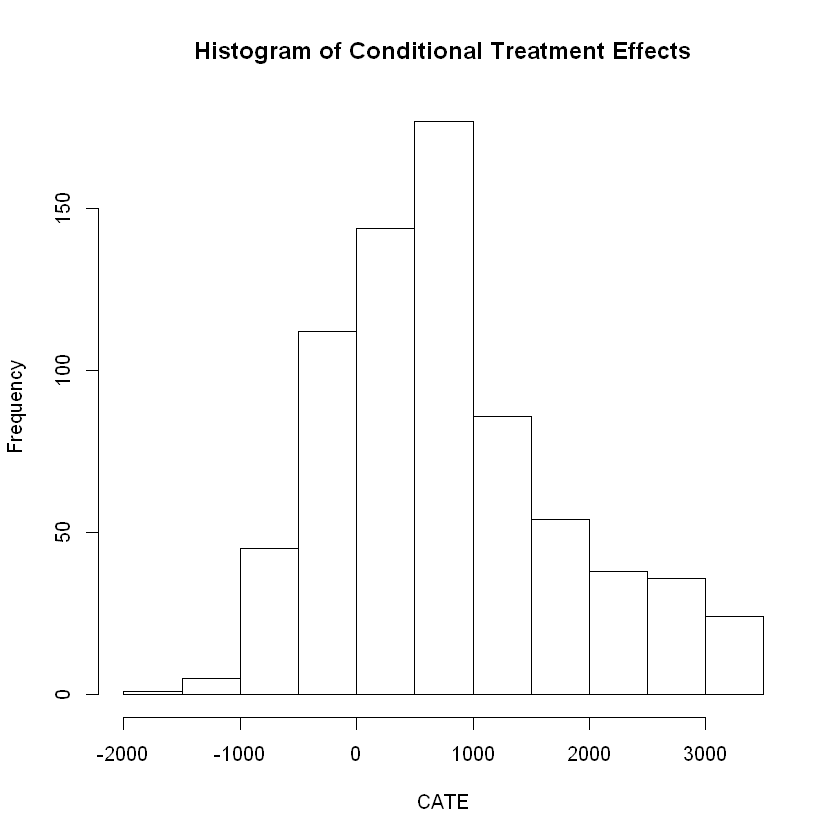

In [21]:
hist(data_nsw$t_hat, main = "Histogram of Conditional Treatment Effects", xlab = "CATE")

### Check for Heterogeneity (2)

A second analysis is to check for heterogeneity across some covariates. Since the trees produce splits such that treatment variation is maximized for the two next produced leafs as explained in the first section, one can check which variables have been used quite often to make splits by the trees. In order to obtain these variables the "variable importance" function of the [grf](https://grf-labs.github.io/grf/reference/index.html) package can be used.
Here, the variables "age", "education" and "re75" have been used the most by the trees. Therefore, it seems plausible to check for differences in CATE between different levels within these covariates.

Indeed, the boxplots below show some heterogeneity "when we change a single covariate, while keeping all the other covariates at some fixed value" (Athey et al. 2020). Especially people around 30 years old and people with a higher degree of education seem to have particular large treatment effects. Furthermore, the treatment effect seems to be negatively correlated with the pretreatment earnings, that is people being on the lower side of income before treatment benefit more from the jobmarket training. This finding implicates that the program addresses the people who should in the end benefit the most from it. On the other hand, it also implicates that people earning more before treatment should be addressed by some other kind of jobmarket program, which might also have a positive effect on the higher income group.

In [22]:
#### Variable Importance
select_index
colnames(X[,select_index])

[1] 1 2 7

[1] "age"       "education" "re75"

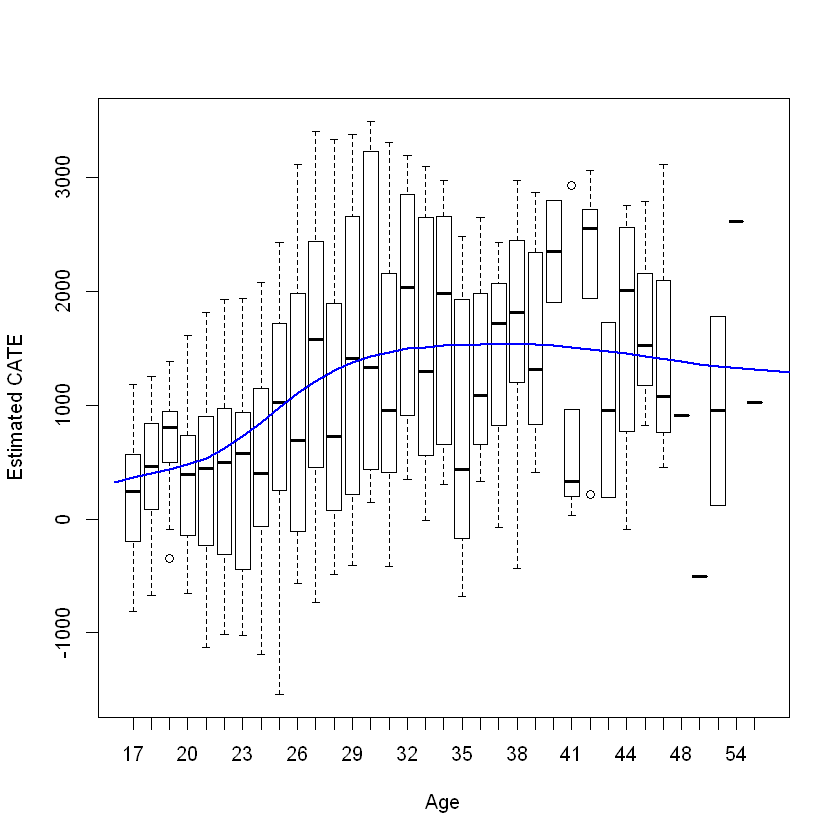

In [23]:
boxplot(data_nsw$t_hat ~ X[,1], ylab = "Estimated CATE", xlab = "Age")
lines(smooth.spline(-17 +X[,1], data_nsw$t_hat, df = 5), lwd = 2, col = 4)

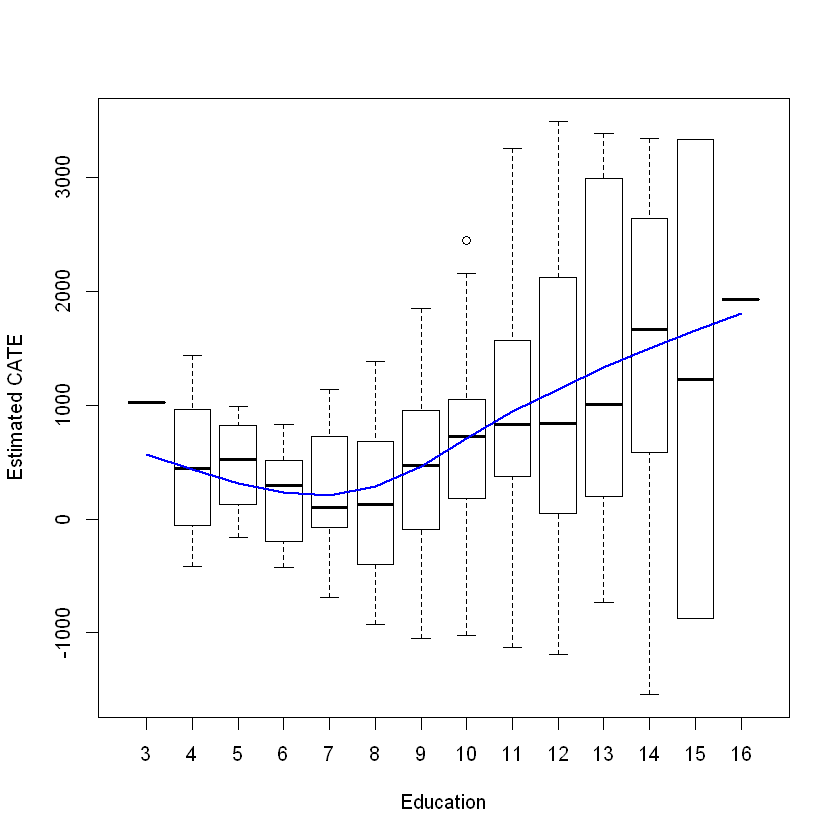

In [24]:
boxplot(data_nsw$t_hat ~ X[,2], ylab = "Estimated CATE", xlab = "Education")
lines(smooth.spline(-2 +X[,2], data_nsw$t_hat, df = 5), lwd = 2, col = 4)

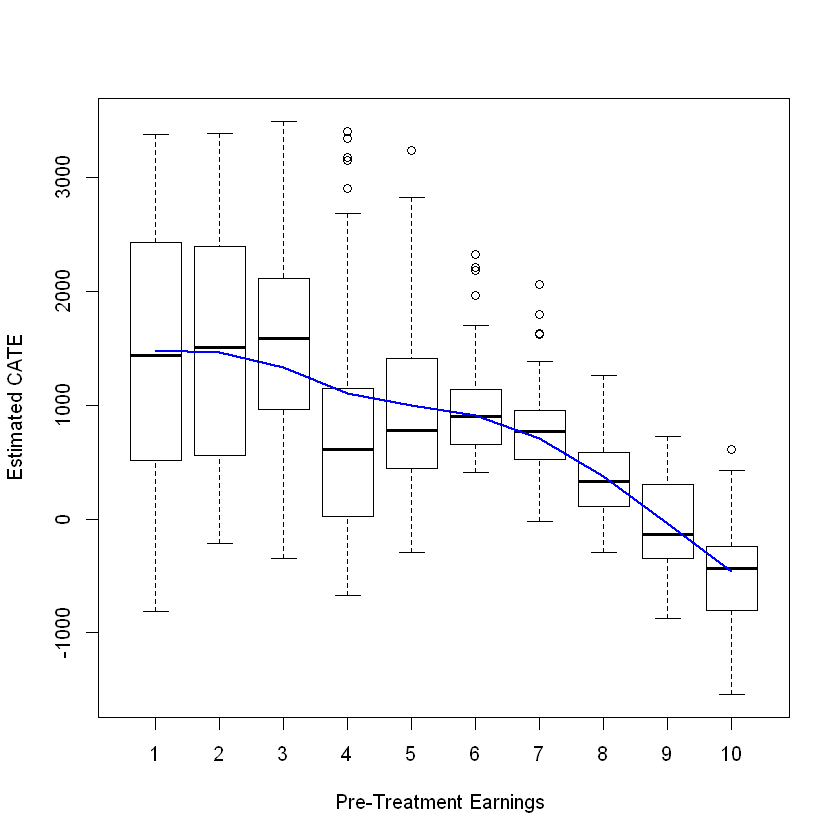

In [25]:
data_nsw$re75fac <- factor(ntile(data_nsw$re75, n=10))
boxplot(data_nsw$t_hat ~ data_nsw$re75fac, ylab = "Estimated CATE", xlab = "Pre-Treatment Earnings ")
lines(smooth.spline(data_nsw$re75fac, data_nsw$t_hat, df = 5), lwd = 2, col = 4)

## 4.) Conclusion<a id="conclusion"></a>

In this project I compared the performance of causal forests in identifying heterogeneous treatment effects. Causal forests can be thought of as a matching estimatation  method, choosing the closest neighbors in order to construct a counterfactual, i.e. matching observations that have fallen in the same leaf. Of all the considered cases causal forests perform exceptionally well when some of the regressors are correlated or some higher degree polynomials and interactions have been added to the data generating process respectively. They also performed decently when selection bias is present, which might be interesting for observational studies where treatment randomization can't always be assured. In terms of dimensionality, performance decreases in the number of regressors, but keeps up fairly well in large samples. As an application the Lalonde (1986) data set was reconsidered in identifying treatment effects within different subgroups. Workers around 30 years old having a higher degree of eduction seem to profit the most from the NSW jobmarket program. Furthermore, workers on the lower side of income before treatment experienced higher treatment effects from the jobmarket training. Because of the good performance in identifying heterogeneity, causal forests seem to be a good tool in evaluating the effectiveness of programs for different subgroups. After all causal forests allow for a more precise evaluation, i.e. if some desired target group has been addressed, rather than only estimating the Average Treatment Effect of the whole sample.    

## References <a id="references"></a>

* **Athey & Imbens (2015).** [Recursive partitioning for heterogeneous causal effects](https://www.pnas.org/content/113/27/7353). Colloquium Paper.


* **Athey & Wager (2015).** [Estimation and Inference of Heterogeneous Treatment Effects using Random Forests](https://arxiv.org/abs/1510.04342). 


* **Athey & Wager (2019).** [Estimating Treatment Effects with Causal Forests: An Application](https://www.gsb.stanford.edu/faculty-research/working-papers/estimating-treatment-effects-causal-forests-application). Working Paper No. 3786. 


* **Athey, Wager, Hadad, Klosin, Muhelbach, Nie & Schaelling (2020).** [Tutorial: Estimation of Heterogeneous Treatment Effects](https://gsbdbi.github.io/ml_tutorial/hte_tutorial/hte_tutorial.html). Tutorial for “Machine Learning and Causal Inference” class.


* **Cunningham (2021).** [Causal Inference: The Mixtape](https://mixtape.scunning.com). Yale University Press.


* **Dehejia & Wahba (1998).** [Propensity Score Matching Methods for Non-experimental Causal Studies](https://www.nber.org/papers/w6829). NBER Working Paper 6829.


* **Farbmacher, Kögel & Spindler (2019).** [Heterogeneous Effects of Poverty on Cognition](https://www.mpisoc.mpg.de/en/social-policy-mea/publications/detail/publication/heterogeneous-effects-of-poverty-on-cognition/). MEA Discussion Paper (06-2019).


* **Hastie, James, Witten & Tibshirani (2013).** An Introduction to Statistical Learning: with Applications in R. Springer Texts in Statistics.



* **Hitsch & Misra (2018).** [Heterogeneous Treatment Effects and Optimal Targeting Policy Evaluation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3111957). Randomized Social Experiments eJournal (2018).


* **Lalonde (1986).** [Evaluating the Econometric Evaluations of Training Programs with Experimental Data](https://www.jstor.org/stable/1806062). American Economic Review 76 (4): 604–20.


* **Powers, Qian, Jung, Schuler, Shah, Hastie & Tibshirani (2017).** [Some methods for heterogeneous treatment effect estimation in high-dimensions](https://web.stanford.edu/~hastie/Papers/PM_Powers_SIM.pdf).Stat Med. 2018 May 20;37(11):1767-1787. 


* **Reference: Generalized Random Forest.** [grf package description](https://grf-labs.github.io/grf/reference/index.html). Github.